# Analise de Consumo de Energia Elétrica pela Industria de Aço

- https://www.kaggle.com/datasets/csafrit2/steel-industry-energy-consumption

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

## Data Extraction

In [2]:
df = pd.read_csv('Steel_industry_data.csv')
display(df.head())

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load
3,01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,3600,Weekday,Monday,Light_Load
4,01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,4500,Weekday,Monday,Light_Load


- A feature NSM (Número de segundos a partir da meia-noite) foi removida, pois como se trata de uma feature continua de tempo e o dataset já é composto por uma outra feature de tempo (date), não havia necessidade de mante-la.

In [3]:
df = df.drop('NSM', axis = 1)

- Verificando as colunas (features) do dataset

In [4]:
df = df.rename(columns = {'Lagging_Current_Reactive.Power_kVarh': 'Lagging_Current_Reactive_Power_kVarh'})
df.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive_Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   WeekStatus                            35040 non-null  object 
 8   Day_of_week                           35040 non-null  object 
 9   Load_Type                             35040 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.7+ MB


- Correlação entre as variáveis

In [6]:
df.corr()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor
Usage_kWh,1.000000,0.896150,-0.324922,0.988180,0.385960,0.353566
Lagging_Current_Reactive_Power_kVarh,0.896150,1.000000,-0.405142,0.886948,0.144534,0.407716
Leading_Current_Reactive_Power_kVarh,-0.324922,-0.405142,1.000000,-0.332777,0.526770,-0.944039
CO2(tCO2),0.988180,0.886948,-0.332777,1.000000,0.379605,0.360019
Lagging_Current_Power_Factor,0.385960,0.144534,0.526770,0.379605,1.000000,-0.519967
Leading_Current_Power_Factor,0.353566,0.407716,-0.944039,0.360019,-0.519967,1.000000


In [7]:
df.describe()

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000


In [8]:
def calculo_estatistico(coluna):
  media = coluna.mean()
  moda = coluna.mode()
  mediana = coluna.median()
  variancia = coluna.var()
  desvio_padrao = coluna.std()
  return f'Média: {media:.2f}\nModa: {moda[0]}\nMediana: {mediana:.2f}\nVariância: {variancia:.2f}\nDesvio Padrão: {desvio_padrao:.2f}'

In [9]:
colunas_numericas = df[['Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor']]
for coluna in colunas_numericas:
  print(f'Coluna: {coluna}')
  print(calculo_estatistico(df[coluna]))
  print('-'*50)

Coluna: Usage_kWh
Média: 27.39
Moda: 3.06
Mediana: 4.57
Variância: 1118.53
Desvio Padrão: 33.44
--------------------------------------------------
Coluna: Lagging_Current_Reactive_Power_kVarh
Média: 13.04
Moda: 0.0
Mediana: 5.00
Variância: 265.89
Desvio Padrão: 16.31
--------------------------------------------------
Coluna: Leading_Current_Reactive_Power_kVarh
Média: 3.87
Moda: 0.0
Mediana: 0.00
Variância: 55.12
Desvio Padrão: 7.42
--------------------------------------------------
Coluna: CO2(tCO2)
Média: 0.01
Moda: 0.0
Mediana: 0.00
Variância: 0.00
Desvio Padrão: 0.02
--------------------------------------------------
Coluna: Lagging_Current_Power_Factor
Média: 80.58
Moda: 100.0
Mediana: 87.96
Variância: 358.02
Desvio Padrão: 18.92
--------------------------------------------------
Coluna: Leading_Current_Power_Factor
Média: 84.37
Moda: 100.0
Mediana: 100.00
Variância: 927.60
Desvio Padrão: 30.46
--------------------------------------------------


- Mapa de Calor que mostra as coorrelações entre as varráveis de forma mais intuitiva

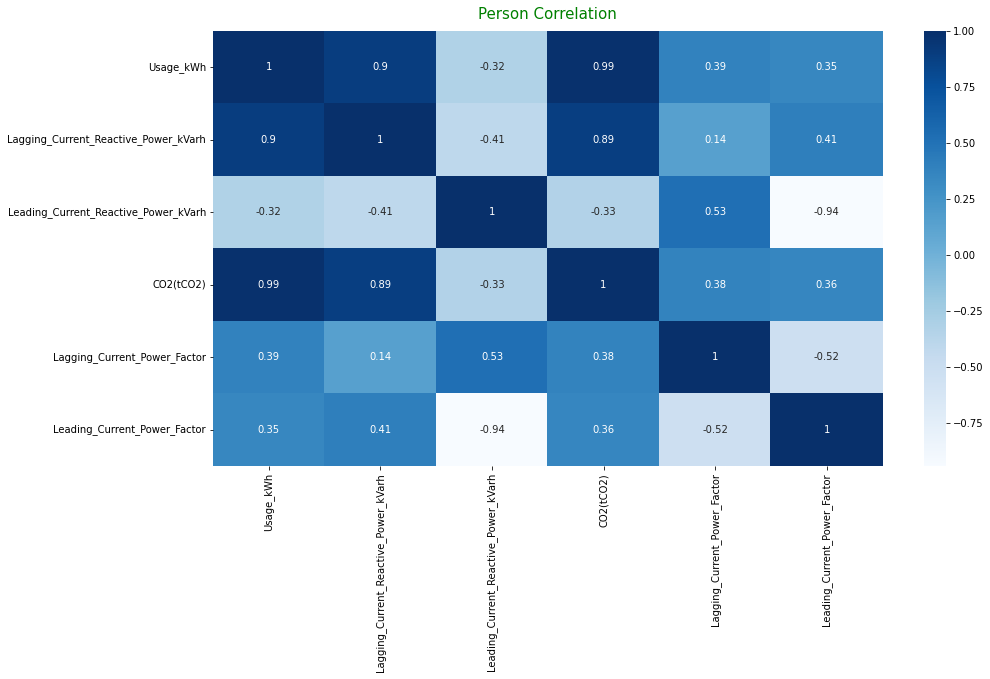

In [10]:
plt.figure(figsize = (15, 8))
sns.heatmap(df.corr(), annot = True, cmap = 'Blues')
plt.title('Person Correlation', fontsize = 15, color = 'g', pad = 12, loc = 'center')
plt.savefig('HeatMap_Correlation')
plt.show()

- Entre as features de Lagging_Current_Reactive_Power e Usage_kWh tem-se uma correlação de 0.9, indicando que, com o aumento do uso de energia elétrica, por meio de equipamentos constituidos de partes indutivas para a geração de aço, consequentemente tornando essas duas variáveis correlacionadas diretamente.

- Agora, entre as features de Lagging_Current_Reactive_Power e CO2(tCO2) com uma correlação de 0.99, indicando que, com o aumento tanto do consumo de energia por essas maquinas indutivas, como consequencia, o aumento de potência reativa indutiva, há o aumento da produção de Dióxido de carbono, indicando que, em alguma parte do processo fabríl da produção de aço. Há uma correlação direta muito forte entre o a energia usada e a produção de CO2.

- Equação de Correlação de Pearson

In [11]:
def correlacao_pearson(df, coluna1, coluna2):
  if len(df[coluna1]) == len(df[coluna2]):
    n = len(df[coluna1])
    result = numerador = denominador1 = denominador2 =  0
    media_coluna1 = df[coluna1].mean()
    std_coluna1 = df[coluna1].std()
    media_coluna2 = df[coluna2].mean()
    std_coluna2 = df[coluna2].std()
    for i in range(n):
      numerador += (df[coluna1][i] - media_coluna1) * (df[coluna2][i] - media_coluna2)
      denominador1 += (df[coluna1][i] - media_coluna1)**2
      denominador2 += (df[coluna2][i] - media_coluna2)**2

    result = numerador / np.sqrt(denominador1 * denominador2)
    return result

In [12]:
p_value = correlacao_pearson(df, 'Lagging_Current_Reactive_Power_kVarh','Usage_kWh')
print(p_value)

0.8961499010002867


## Exploratory Data Analisy (EDA)

- Olhando para todo o dataset, verificamos para cada periodo de tempo registrado, de 15 em 15 segundos, apartir da 00h00, os maiores consumos. Abaixo está uma amostra dos maiores consumos de energia para todos os dados registrados e contidos nesta base de dados.

In [13]:
maiores_consumos = pd.pivot_table(df, index = 'date', values = 'Usage_kWh', aggfunc = {'Usage_kWh': np.max})
display(maiores_consumos.head(10)) # mostra os 10 primeiros registros

,Usage_kWh
date,
01/01/2018 00:00,3.42
01/01/2018 00:15,3.17
01/01/2018 00:30,4.00
01/01/2018 00:45,3.24
01/01/2018 01:00,3.31
01/01/2018 01:15,3.82
01/01/2018 01:30,3.28
01/01/2018 01:45,3.60
01/01/2018 02:00,3.60


- O gráfico abaixo implica nos mariores consumos de energia, para as 50 primeiras amostrar, em decorrencia do tempo, apartir da 00h00, mostrando que o mesmo tem uma tendencia de alta, conforme as horas vão se passando.

<Figure size 1080x504 with 0 Axes>

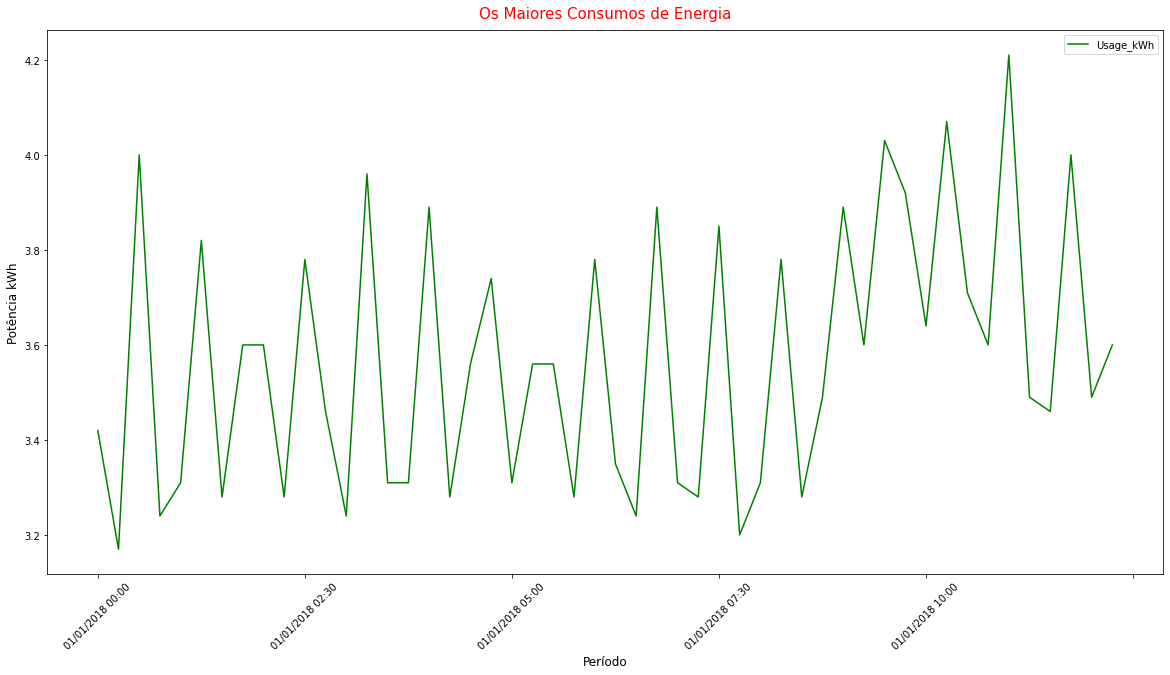

In [14]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = plt.figure(figsize = (15, 7)) # tamanho da imagem x = 15, y = 7
#.sort_values(by = 'Usage_kWh', ascending = False)
ax = maiores_consumos[:50].plot(kind = 'line', color = 'green')
# pega apenas as 50 primeiras linhas, ordena pela variável "Usage_kWh"
ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)
ax.set_title('Os Maiores Consumos de Energia', fontsize = 15, color = 'r', pad = 12, loc = 'center')
ax.set_xlabel('Período', fontsize = 12)
ax.set_ylabel('Potência kWh', fontsize = 12)
plt.savefig('Maior_Consumo')
plt.show()

- O gráfico abaixo demostra os quartis para cada feature numérica da base, contendo sua média e caso exista, valores discrepantes (Outliers). Mas vale indicar que o mesmo também indica que os dados estão em escalas diferentes, sendo assim, se necessário, torna-los todos em bases iguais, como valores entre 0 e 1.

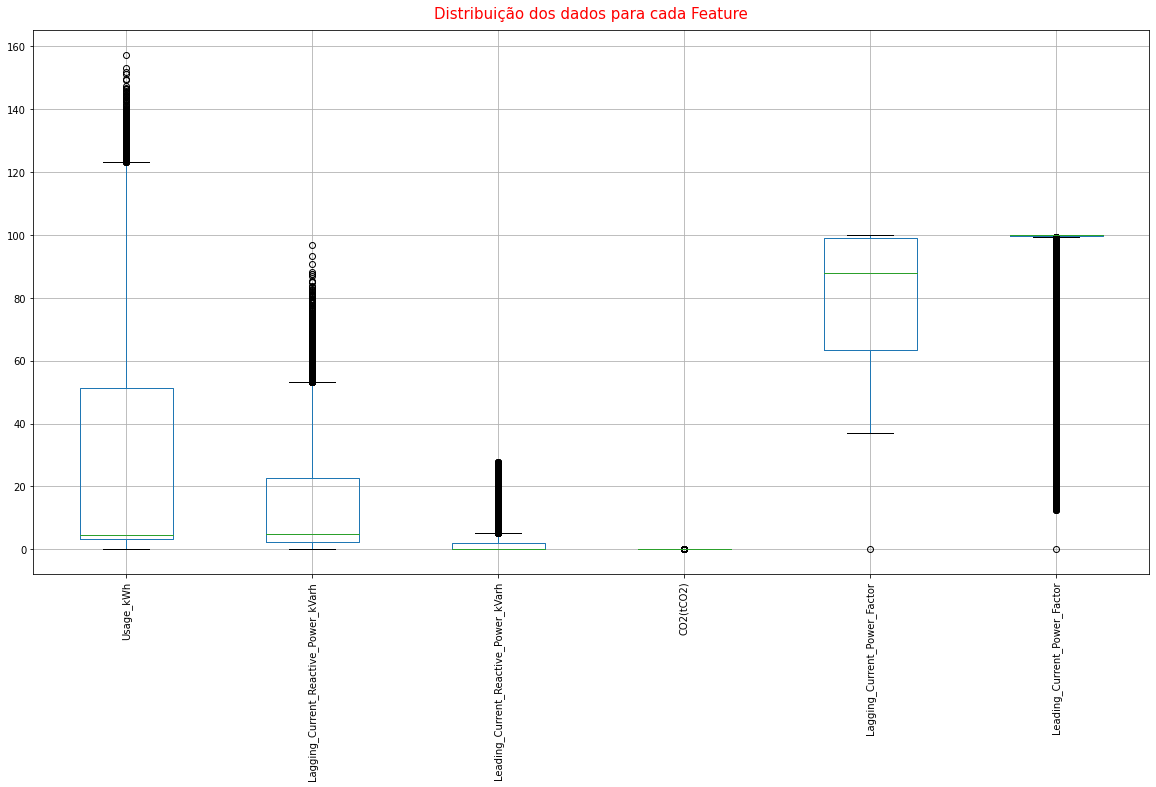

In [15]:
plt.rcParams['figure.figsize'] = (20, 10)
ax2 =  df.boxplot(['Usage_kWh', 'Lagging_Current_Reactive_Power_kVarh', 'Leading_Current_Reactive_Power_kVarh',
                    'CO2(tCO2)', 'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor'])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)
plt.title('Distribuição dos dados para cada Feature', fontsize = 15, color = 'r', pad = 12, loc = 'center')
plt.savefig('Dataset_Boxplot')
plt.show()

- Para cada tipo de carga, é possivel analisár e verificar que o consumo de energia elétrica tem suas diferençãs tanto para o tipo de carga, como para o dia de utilização, ou seja, em dia de final de semana, o consumo de energia elétrica é menor.
- Porem que, mesmo que o consumo de energia seja menor aos finais de semana, o para cada tipo de carga, há um consumo elevado, tendo uma diferença de 2 a 3 vezes durante a semana.

In [16]:
pd.pivot_table(df, index = ['Load_Type','Day_of_week','WeekStatus'], values = ['Usage_kWh'], aggfunc = {'Usage_kWh':np.mean})

Usage_kWh
Load_Type    Day_of_week WeekStatus           
Light_Load   Friday      Weekday     11.361442
             Monday      Weekday      8.805459
             Saturday    Weekend      7.072210
             Sunday      Weekend      4.171106
             Thursday    Weekday     11.803964
             Tuesday     Weekday     10.510040
             Wednesday   Weekday     10.780560
Maximum_Load Friday      Weekday     61.043700
             Monday      Weekday     66.278233
             Saturday    Weekend     41.529605
             Sunday      Weekend     29.195662
             Thursday    Weekday     64.522758
             Tuesday     Weekday     66.023359
             Wednesday   Weekday     62.358359
Medium_Load  Friday      Weekday     42.220494
             Monday      Weekday     43.097231
             Saturday    Weekend     17.547648
             Sunday      Weekend     16.368934
             Thursday    Weekday     44.986200
             Tuesday     Weekday     45.020797
             Wednesday   Weekday     40.462379

- Aqui se tem uma representação gráfica de como é a diferença entre o consumo de energia por tipo de carga, sendo dados tanto de finais de semana, como durante a semana.

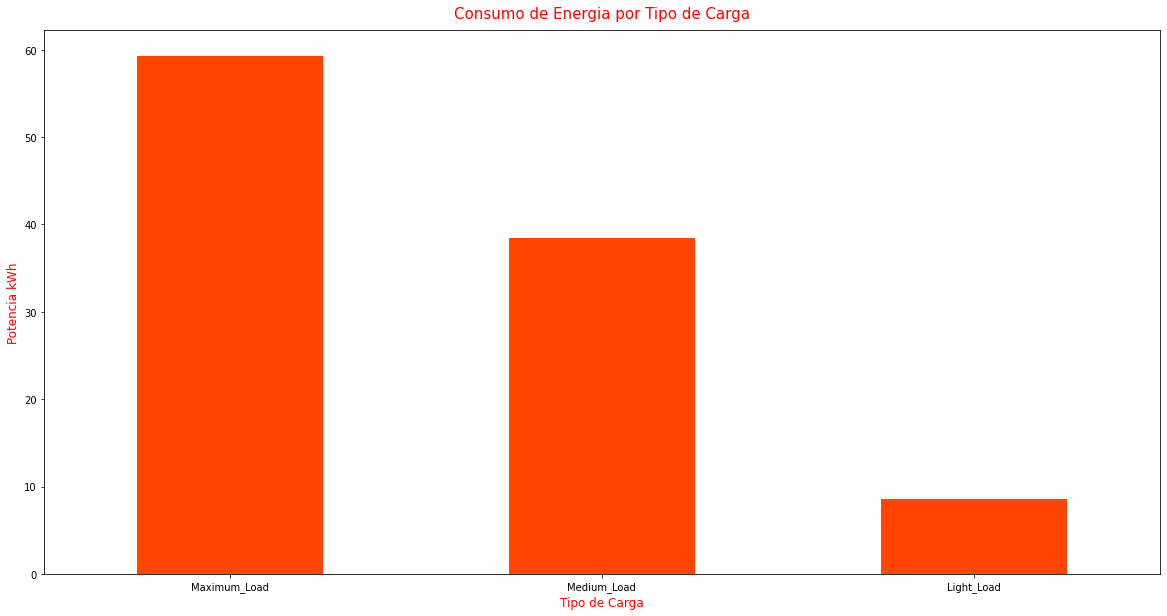

In [17]:
# Visualizando o consumo de energia Base para cada tipo de carga
plt.rcParams['figure.figsize'] = (20, 10)
ax = df.groupby('Load_Type')['Usage_kWh'].mean().sort_values(ascending = False).plot(kind = 'bar', color = 'orangered')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
ax.set_title('Consumo de Energia por Tipo de Carga', fontsize = 15, pad = 12, color = 'r', loc = 'center')
ax.set_xlabel('Tipo de Carga', fontsize = 12, color = 'r')
ax.set_ylabel('Potencia kWh', fontsize = 12, color = 'r')
plt.savefig('Consumo_Por_Carga') # salva
plt.show()

- Consumo de energia nos tipos de cargas para dias da semana (Weekday) e Finais de Semana (Weekend)

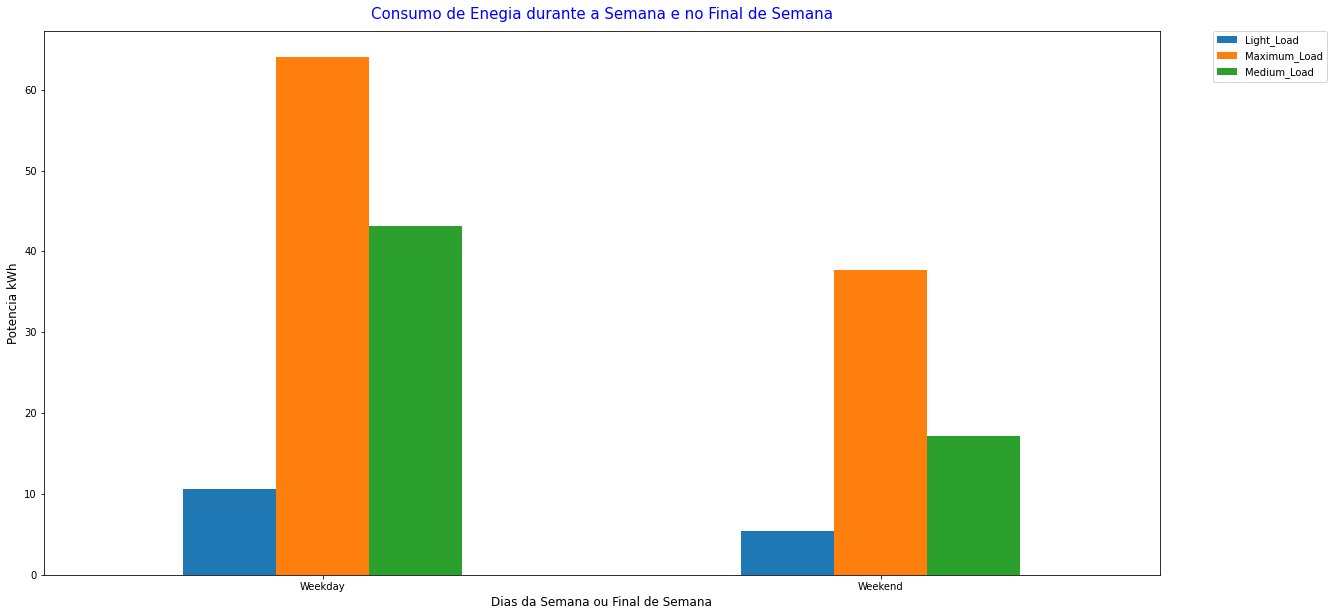

In [18]:
plt.rcParams['figure.figsize'] = (20, 10)
ax3 = df.groupby(['WeekStatus', 'Load_Type'])['Usage_kWh'].mean().unstack().plot(kind = 'bar')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 0)
ax3.set_title('Consumo de Enegia durante a Semana e no Final de Semana', fontsize = 15, pad = 12, color = 'b', loc = 'center')
ax3.set_xlabel('Dias da Semana ou Final de Semana', fontsize = 12)
ax3.set_ylabel('Potencia kWh', fontsize = 12)
plt.legend(bbox_to_anchor = (1.15, 1), borderaxespad = 0) # Joga a caixa de legenda para fora do gráfico
plt.savefig('Consumo_por_Semana')
plt.show()

- Consumo de energia elétrica pelo tipo de carga para cada dias da semana, desta forma, pode-se viasualizar que o consumo, independete do tipo de carga, é maior durante a semana do que aos finais de semana.

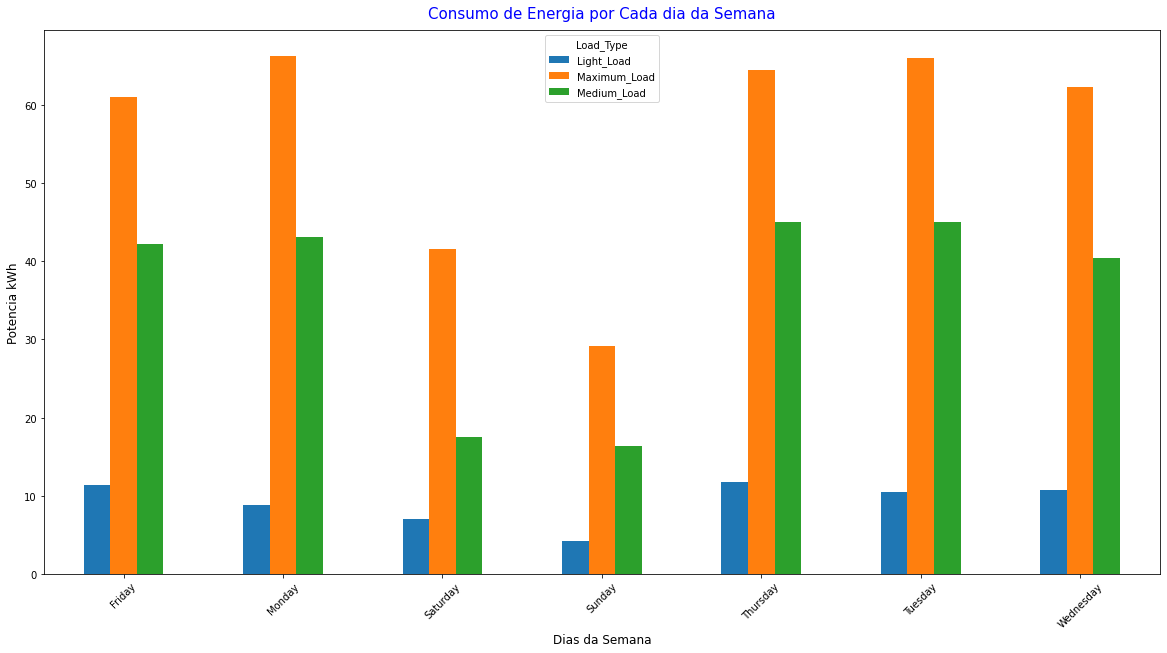

In [19]:
plt.rcParams['figure.figsize'] = (20, 10)
ax4 = df.groupby(['Day_of_week', 'Load_Type'])['Usage_kWh'].mean().unstack().plot(kind = 'bar')
ax4.set_xticklabels(ax4.get_xticklabels(), rotation = 45)
ax4.set_title('Consumo de Energia por Cada dia da Semana', fontsize = 15, pad = 12, color = 'b', loc = 'center')
ax4.set_xlabel('Dias da Semana', fontsize = 12)
ax4.set_ylabel('Potencia kWh', fontsize = 12)
plt.savefig('Consumo_por_dia')
plt.show()

- Visualizando o consumo de energia em numero de segundos a partir da meia noite para cada tipo de caga e em durante a semana e ao final de semana

- Distribuição de Frequência para todas as variáveis

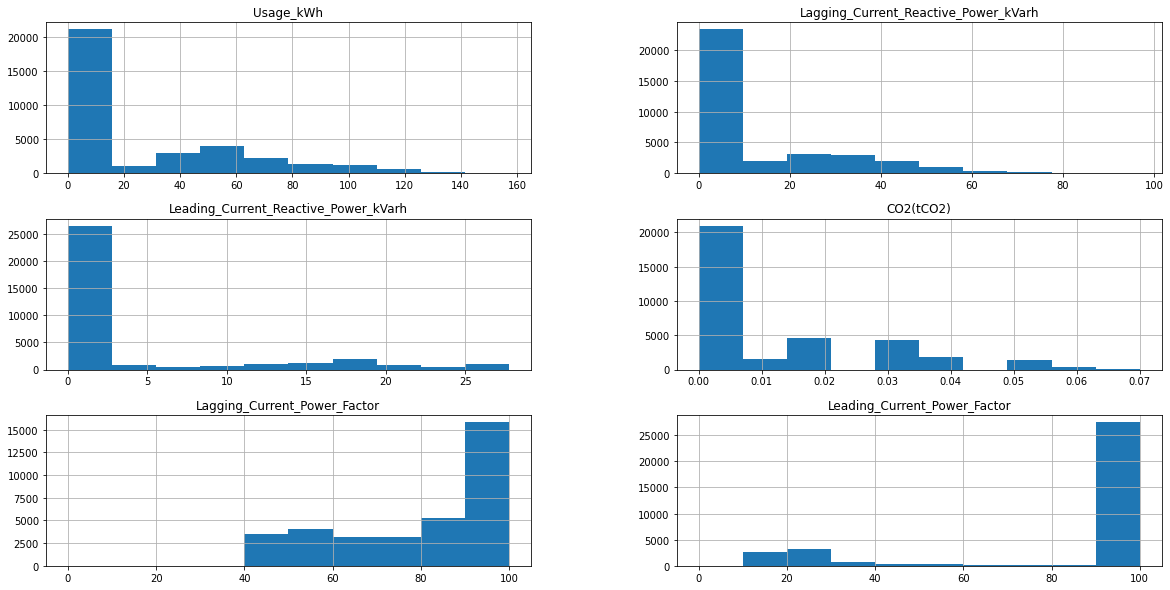

In [20]:
df.hist(figsize = (20, 10))
plt.show()

- Justificativas de Tratamento:
    - A feature NSM (Número de segundos a partir da meia-noite) foi removida, pois como se trata de uma feature continua de tempo e o dataset já é composto por uma outra feature de tempo (date), não havia necessidade de mante-la.
    - Em representações anteriores, como o gráfico boxplot, que a maioria das features do dataset continham em sim, valores descrepantes (Outliers). Como também não foi realizado o processo de normalização, isso tudo decorrente do fato que os modelos de Machine Learning apresentados, não necessitaram destes tratamentos para apresentarem bons resultados de acuracia.

## Modelos de Regressão

- Alguns modelo de Machine Learning, em muitas das vezes não aceitam dados não númericos, como valores de textos, como é o caso das features categóricas aprensetadads neste dataset, sendo assim, um dos métodos, e o que será utilizado neste trabalho, é a transformação destas features categóricas em novas colunas de forma binária, ou seja, transformar os valores de texto de cada coluna categórica em uma nova coluna, recebendo valores de 0 e 1.

In [21]:
# transformando a coluna data em indice
df = df.set_index('date')

# Transformando valores categoricos em novas features categoricas
df = pd.get_dummies(df, drop_first= True)
display(df.head())

,Usage_kWh,Lagging_Current_Reactive_Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,WeekStatus_Weekend,Day_of_week_Monday,Day_of_week_Saturday,Day_of_week_Sunday,Day_of_week_Thursday,Day_of_week_Tuesday,Day_of_week_Wednesday,Load_Type_Maximum_Load,Load_Type_Medium_Load
date,,,,,,,,,,,,,,,
01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,0,1,0,0,0,0,0,0,0
01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,0,1,0,0,0,0,0,0,0
01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,0,1,0,0,0,0,0,0,0
01/01/2018 01:00,3.31,3.56,0.0,0.0,68.09,100.0,0,1,0,0,0,0,0,0,0
01/01/2018 01:15,3.82,4.50,0.0,0.0,64.72,100.0,0,1,0,0,0,0,0,0,0


- A função abaixo, é uma forma mais prática, encontrada para utilizar os principais métodos de avaliação de modelos de Regressão, tendo como avaliadores:
    - R2_Score;
    - RMSE;
    - MSE;
    - MAE.

In [22]:
def avalia_modelo(y_pred, y_test):
  R2 = r2_score(y_pred, y_test)
  RMSE = np.sqrt(mean_squared_error(y_pred, y_test))
  MAE = mean_absolute_error(y_pred, y_test)
  MSE = mean_squared_error(y_pred, y_test)
  return f'R2: {R2:.2%}\nMSE: {MSE:.2f}\nRMSE: {RMSE:.2f}\nMAE: {MAE:.2f}'

- Para o estudo deste caso, queremos prever qual será o consumo de energia elétrica (Usage_kWh) da empresa, decorrente das demais features.

- Separando as features em preditoras(X) e resposta(y)

In [23]:
X = df.drop('Usage_kWh', axis = 1)
y = df['Usage_kWh']

- Separando dados entre valores de treino(train) e teste(test)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 10)
print(f'X_train: linhas = {X_train.shape[0]}, colunas = {X_train.shape[1]}')
print(f'y_train: linhas = {y_train.shape[0]}, colunas = 1')
print(f'X_test: linhas = {X_test.shape[0]}, colunas = {X_test.shape[1]}')
print(f'X_test: linhas = {y_test.shape[0]}, colunas = 1')

X_train: linhas = 26280, colunas = 14
y_train: linhas = 26280, colunas = 1
X_test: linhas = 8760, colunas = 14
X_test: linhas = 8760, colunas = 1


### KNeighborsRegressor

CPU times: user 54 ms, sys: 0 ns, total: 54 ms
Wall time: 55.1 ms
R2: 99.70%
MSE: 3.41
RMSE: 1.85
MAE: 0.79
Score Valores de Treino: 100.00%
Score Valores de Teste: 99.70%


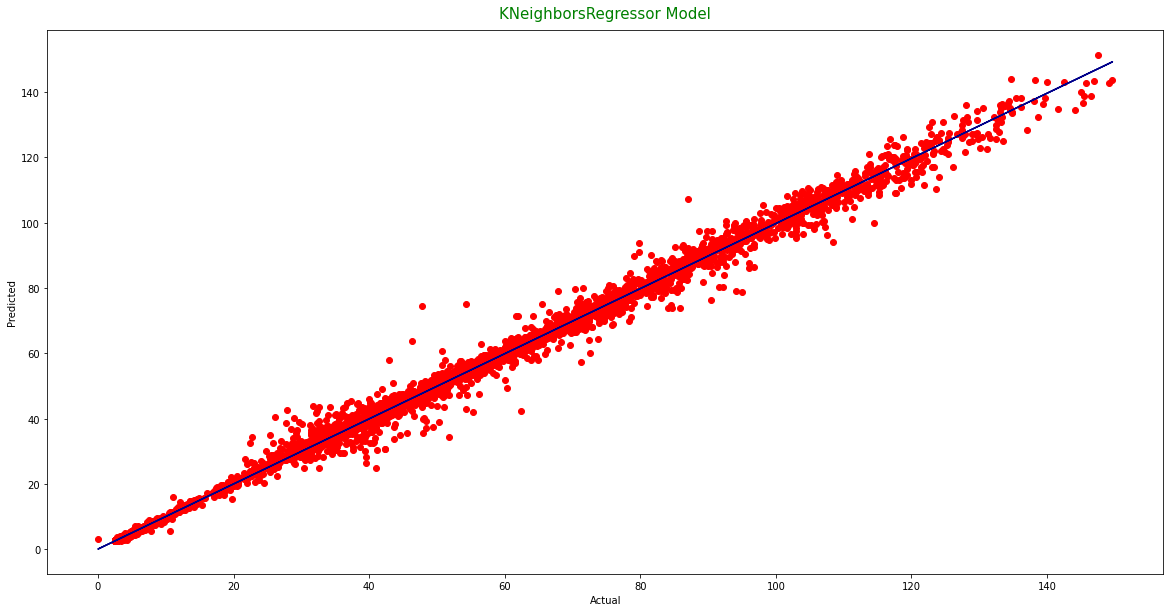

In [25]:
modelo_knn = KNeighborsRegressor(n_neighbors = 1)
%time modelo_knn.fit(X_train, y_train)
y_pred = modelo_knn.predict(X_test)
print(avalia_modelo(y_pred, y_test))
print(f'Score Valores de Treino: {modelo_knn.score(X_train, y_train):.2%}')
print(f'Score Valores de Teste: {modelo_knn.score(X_test, y_test):.2%}')

x = y_test
y = y_pred

plt.title('KNeighborsRegressor Model', fontsize = 15, color = 'g', pad = 12)
plt.plot(x, y, 'o', color = 'r')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color = 'darkblue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('KNeighborsRegressor')
plt.show()

### Linear Regressor

CPU times: user 14.2 ms, sys: 5.15 ms, total: 19.4 ms
Wall time: 29.9 ms
R2: 97.84%
MSE: 24.11
RMSE: 4.91
MAE: 2.59
Score Valores de Treino: 98.09%
Score Valores de Teste: 97.89%
----------------------------------------------------------------------------------------------------
Coeficientes do modelo: [ 3.01006316e-01  7.49793007e-02  1.67646187e+03  1.09698054e-01
  5.69042190e-02  1.26394298e-01  1.13530527e-01 -1.01843190e-01
  2.28237488e-01 -8.71114151e-02  6.31020124e-01  7.52769113e-02
  1.23199148e+00  1.62470434e+00]
-10.683655513556289


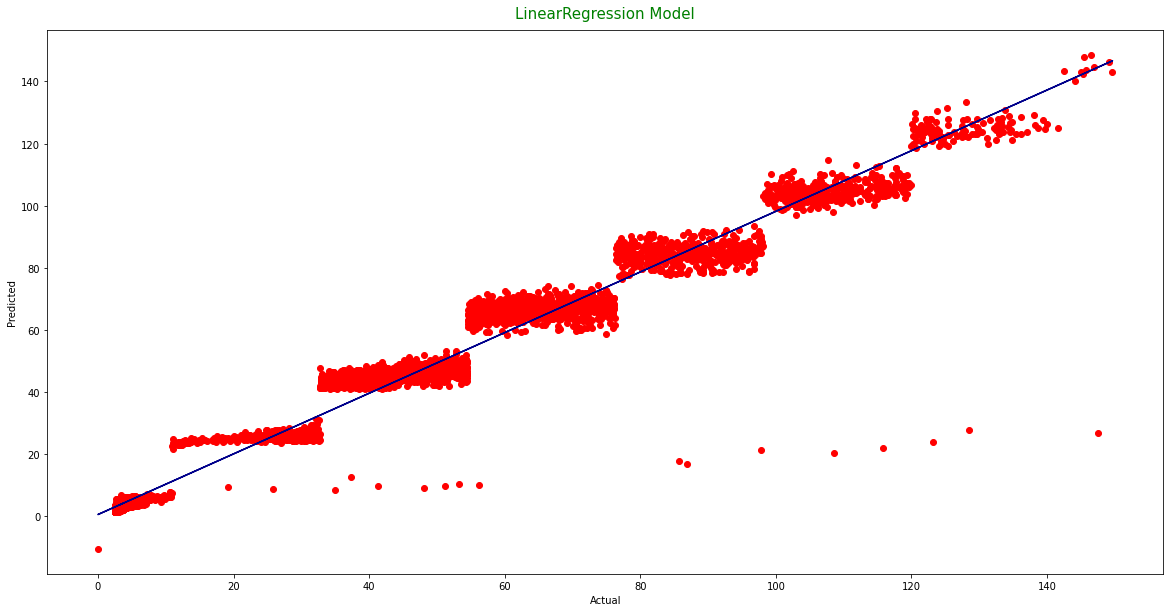

In [26]:
modelo_lr = LinearRegression()
%time modelo_lr.fit(X_train, y_train)
y_pred = modelo_lr.predict(X_test)
print(avalia_modelo(y_pred, y_test))
print(f'Score Valores de Treino: {modelo_lr.score(X_train, y_train):.2%}')
print(f'Score Valores de Teste: {modelo_lr.score(X_test, y_test):.2%}')
print('-'*100)
print(f'Coeficientes do modelo: {modelo_lr.coef_}')
print(f'{modelo_lr.intercept_}')
x = y_test
y = y_pred

plt.title('LinearRegression Model', fontsize = 15, color = 'g', pad = 12)
plt.plot(x, y, 'o', color = 'r')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color = 'darkblue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('LinearRegressor')
plt.show()

### Ridge Regressor

CPU times: user 8.79 ms, sys: 2.23 ms, total: 11 ms
Wall time: 10.2 ms
R2: 96.61%
MSE: 35.97
RMSE: 6.00
MAE: 4.00
Score Valores de Treino: 96.91%
Score Valores de Teste: 96.86%
----------------------------------------------------------------------------------------------------
Coeficientes do Modelo: [ 7.87495779e-01  4.88857412e-02  9.57947019e+02  3.27666600e-01
  1.57744961e-01  5.61095618e-01  2.70817410e-01 -3.25666590e-02
  5.93662276e-01 -1.74876436e-03  5.53478947e-01  2.42249779e-01
  3.79108009e+00  4.49739677e+00]
-36.29516295787111


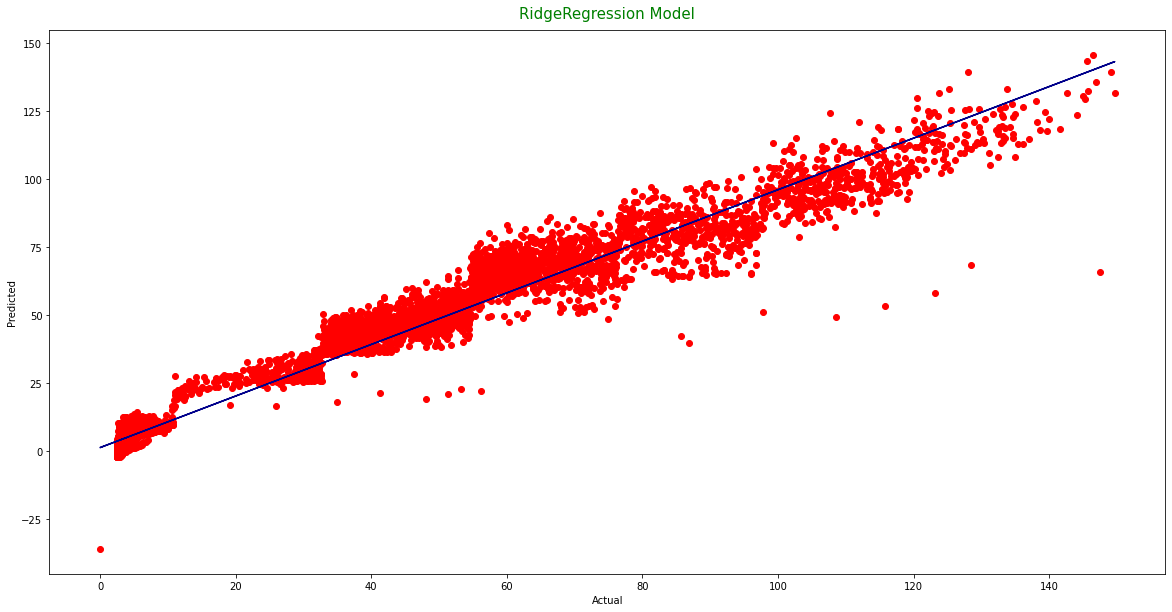

In [27]:
modelo_rd = Ridge(alpha = 0.5)
%time modelo_rd.fit(X_train, y_train)
y_pred = modelo_rd.predict(X_test)
print(avalia_modelo(y_pred, y_test))
print(f'Score Valores de Treino: {modelo_rd.score(X_train, y_train):.2%}')
print(f'Score Valores de Teste: {modelo_rd.score(X_test, y_test):.2%}')
print('-'*100)
print(f'Coeficientes do Modelo: {modelo_rd.coef_}')
print(modelo_rd.intercept_)

x = y_test
y = y_pred

plt.title('RidgeRegression Model', fontsize = 15, color = 'g', pad = 12)
plt.plot(x, y, 'o', color = 'r')

m, b = np.polyfit(x, y, 1)
plt.plot(x, m * x + b, color = 'darkblue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.savefig('RidgeRegression')
plt.show()

## Conclusão

- O modelo que apresentou a melhor eficiencia para predizer o valor de consumo de energia elétrica (Usage_kWh) pela industria de aço, foi o NeighborsRegressor com:
    - Score de treino de 100,00% 
    - Score de Teste de 99,70%
    - RMSE de 1,85 
    - R2_Score de 99,70%. 